In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import torch

from veloproj import *

scv.settings.verbosity = 1

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-6',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/users/cqiao/notebooks/data/organoids.h5ad',
                               '--model-name', 'scEU_model.cpt',
                               '--exp-name', 'CohAE_scEU',
                               '--device', 'cuda:3',
                               '--nb_g_src', "SU",
                               '--ld_nb_g_src', "SU",
                               '--gumbsoft_tau', '1',
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'clusters',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir='/data/users/cqiao/notebooks/data/organoids.h5ad', device='cuda:3', exp_name='CohAE_scEU', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=1.0, h_dim=256, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='SU', log_interval=100, lr=1e-06, lr_decay=0.9, mask_cluster_list=None, model_name='scEU_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='SU', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='clusters', weight_decay=0.0, z_dim=100)

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [
    ("Stem cells", "TA cells"), 
    ("Stem cells", "Goblet cells")]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
}
adata.obs['clusters'] = adata.obs.som_cluster_id.map(cell_mapper).astype('str')
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.68 0.32]
AnnData object with n_obs × n_vars = 3831 × 2000
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'rotated_umap1', 'rotated_umap2', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


or disable the progress bar using `show_progress_bar=False`.
saving figure to file ./figures/scvelo_scEU_stochastical.png


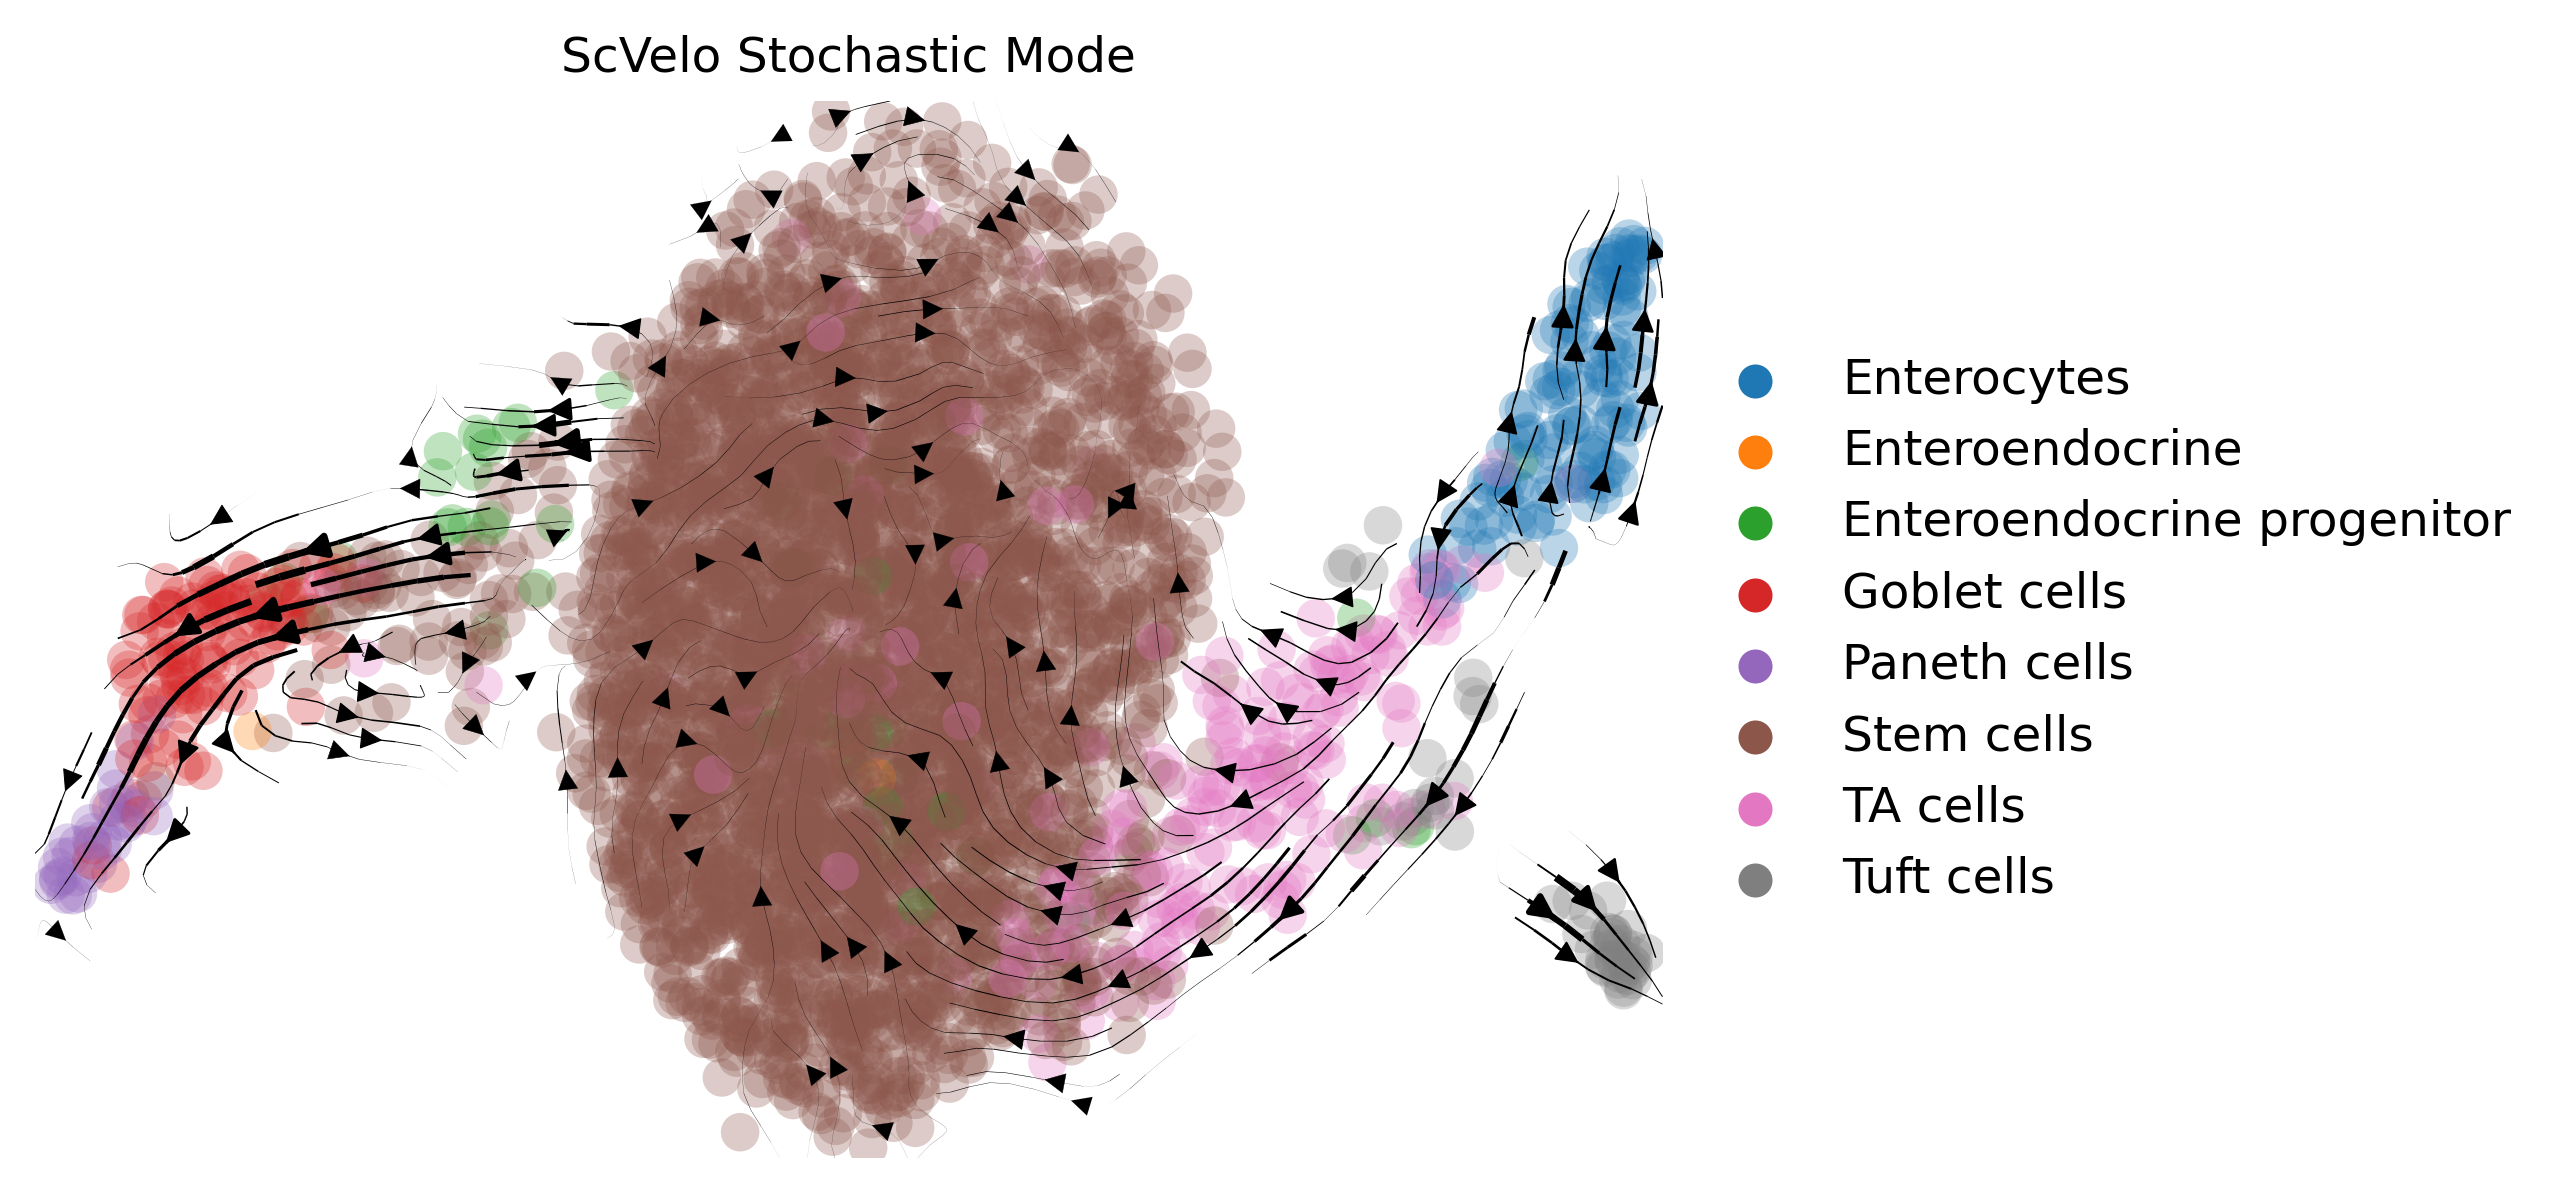

# Cross-Boundary Transition Score (A->B)
{('Stem cells', 'TA cells'): 0.057497818, ('Stem cells', 'Goblet cells'): 0.1164707}
Total Mean: 0.08698426187038422
# Cross-Boundary Velocity Coherence (A->B)
{('Stem cells', 'TA cells'): 0.800268, ('Stem cells', 'Goblet cells'): 0.82834375}
Total Mean: 0.8143059015274048
# Cross-Boundary Direction Correctness (A->B)
{('Stem cells', 'TA cells'): -0.08040366909329222, ('Stem cells', 'Goblet cells'): 0.2063812642439249}
Total Mean: 0.06298879757531634
# In-cluster Coherence
{'Enterocytes': 0.8645226, 'Enteroendocrine': 0.9444058, 'Enteroendocrine progenitor': 0.8498541, 'Goblet cells': 0.85888326, 'Paneth cells': 0.9032606, 'Stem cells': 0.81251144, 'TA cells': 0.84798604, 'Tuft cells': 0.9175368}
Total Mean: 0.8748700618743896
# In-cluster Confidence
{'Enterocytes': 0.8054338132496923, 'Enteroendocrine': 0.8928764164447784, 'Enteroendocrine progenitor': 0.7753144958439995, 'Goblet cells': 0.7913217997109449, 'Paneth cells': 0.7839842386105481, '

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  legend_loc="right margin", vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col,
                                 dpi=350,
                                 title='ScVelo Stochastic Mode', save="scEU_stochastical.png")

exp_metrics['stc_mode'] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")

Train Epoch: 100/20000 	Loss: 0.913160
Train Epoch: 200/20000 	Loss: 0.907657
Train Epoch: 300/20000 	Loss: 0.904143
Train Epoch: 400/20000 	Loss: 0.898437
Train Epoch: 500/20000 	Loss: 0.883368
Train Epoch: 600/20000 	Loss: 0.874142
Train Epoch: 700/20000 	Loss: 0.860075
Train Epoch: 800/20000 	Loss: 0.849514
Train Epoch: 900/20000 	Loss: 0.834879
Train Epoch: 1000/20000 	Loss: 0.819463
Train Epoch: 1100/20000 	Loss: 0.801335
Train Epoch: 1200/20000 	Loss: 0.785643
Train Epoch: 1300/20000 	Loss: 0.772474
Train Epoch: 1400/20000 	Loss: 0.763428
Train Epoch: 1500/20000 	Loss: 0.755572
Train Epoch: 1600/20000 	Loss: 0.750839
Train Epoch: 1700/20000 	Loss: 0.743294
Train Epoch: 1800/20000 	Loss: 0.738210
Train Epoch: 1900/20000 	Loss: 0.729921
Train Epoch: 2000/20000 	Loss: 0.724808
Train Epoch: 2100/20000 	Loss: 0.717757
Train Epoch: 2200/20000 	Loss: 0.713787
Train Epoch: 2300/20000 	Loss: 0.706563
Train Epoch: 2400/20000 	Loss: 0.701409
Train Epoch: 2500/20000 	Loss: 0.690913
Train Epo

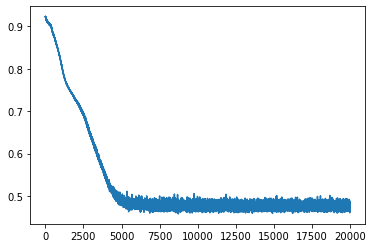

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

saving figure to file ./figures/scvelo_scEU_pojection.png


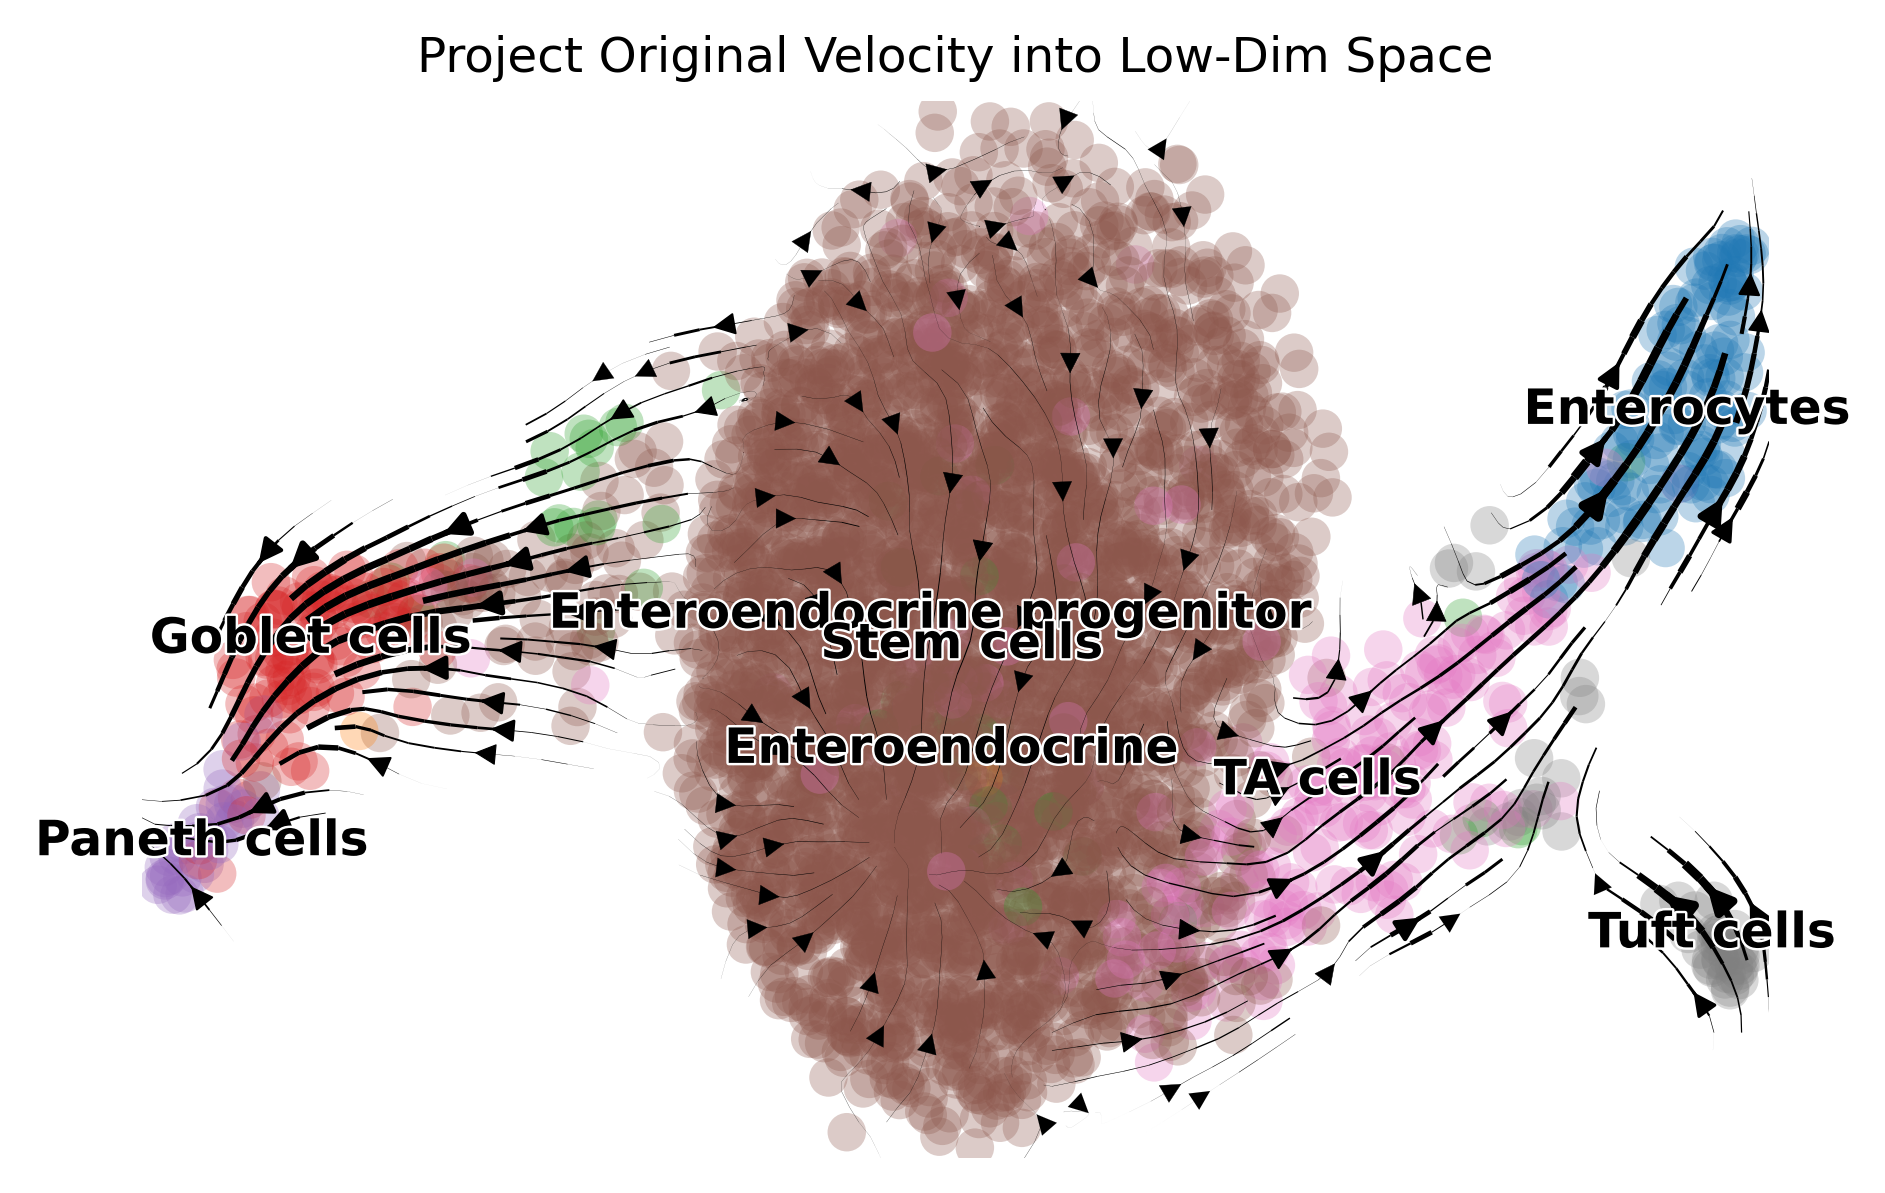

# Cross-Boundary Transition Score (A->B)
{('Stem cells', 'TA cells'): 0.253553, ('Stem cells', 'Goblet cells'): 0.41781077}
Total Mean: 0.33568188548088074
# Cross-Boundary Velocity Coherence (A->B)
{('Stem cells', 'TA cells'): 0.99891573, ('Stem cells', 'Goblet cells'): 0.9997293}
Total Mean: 0.9993225336074829
# Cross-Boundary Direction Correctness (A->B)
{('Stem cells', 'TA cells'): 0.2989113672605398, ('Stem cells', 'Goblet cells'): 0.7842491109204324}
Total Mean: 0.541580239090486
# In-cluster Coherence
{'Enterocytes': 0.999742, 'Enteroendocrine': 0.9998645, 'Enteroendocrine progenitor': 0.99884367, 'Goblet cells': 0.99961406, 'Paneth cells': 0.99980074, 'Stem cells': 0.99937916, 'TA cells': 0.99874276, 'Tuft cells': 0.9990502}
Total Mean: 0.9993796348571777
# In-cluster Confidence
{'Enterocytes': 0.9994781627319753, 'Enteroendocrine': 0.9972064048051834, 'Enteroendocrine progenitor': 0.9983041041037616, 'Goblet cells': 0.9994935718951402, 'Paneth cells': 0.999511627589955, 'Stem 

In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis=args.vis_key, color=[args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    save='scEU_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
    
exp(adata, exp_metrics)

Abundance of ['spliced', 'unspliced']: [0.68 0.32]


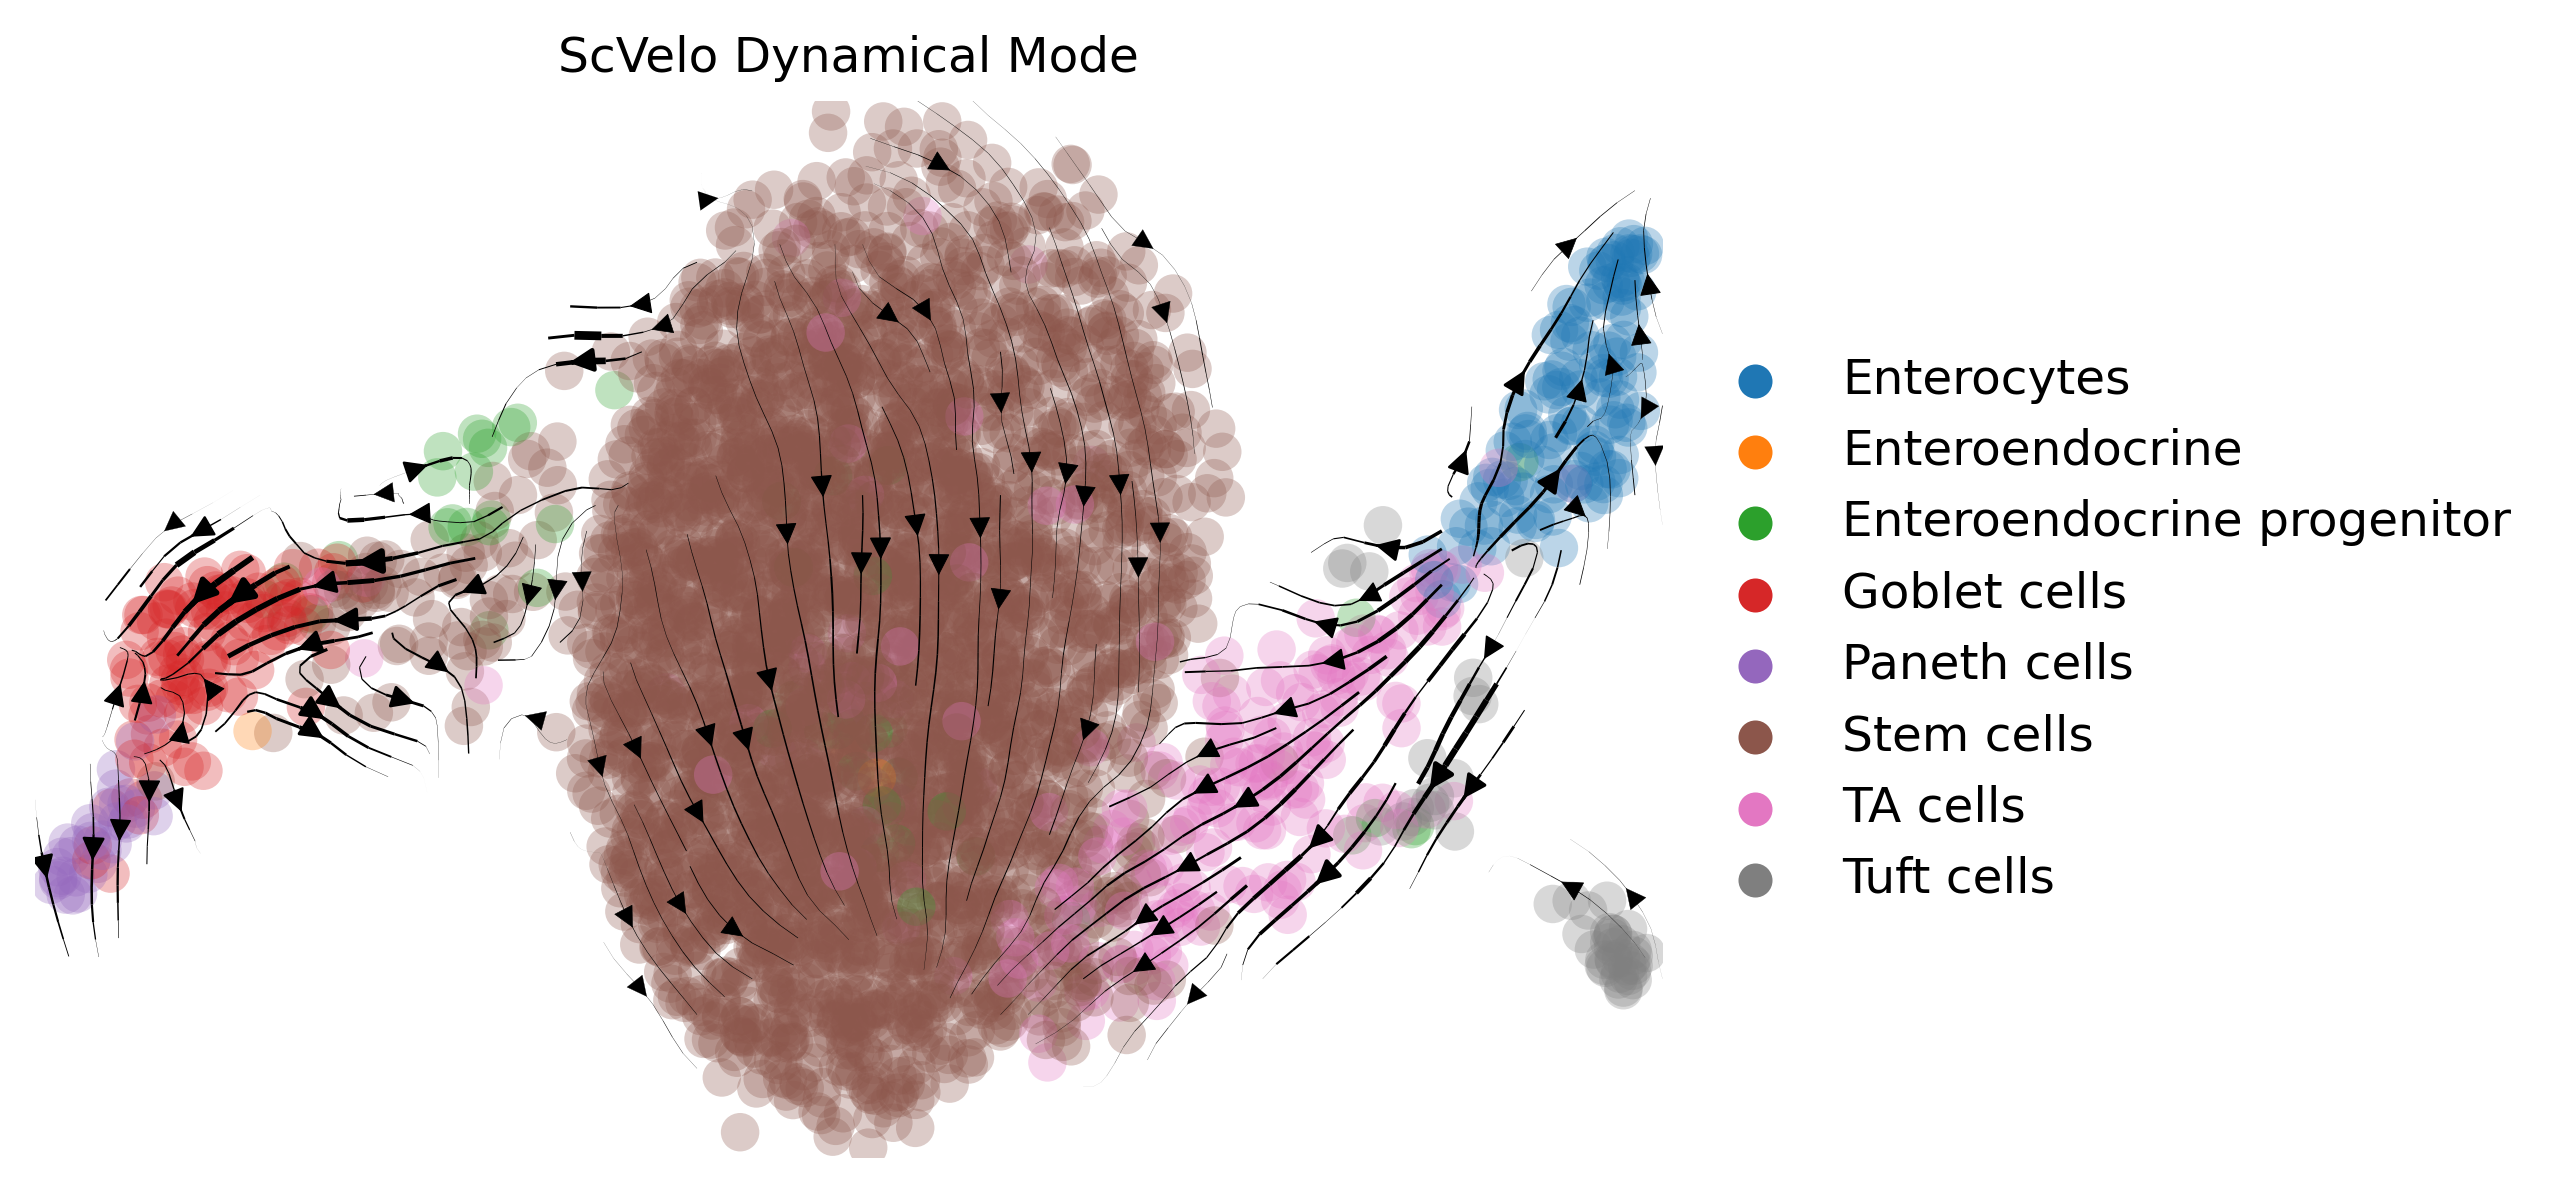

# Cross-Boundary Transition Score (A->B)
{('Stem cells', 'TA cells'): 0.07246588, ('Stem cells', 'Goblet cells'): 0.22305049}
Total Mean: 0.14775818586349487
# Cross-Boundary Velocity Coherence (A->B)
{('Stem cells', 'TA cells'): 0.7398184294899877, ('Stem cells', 'Goblet cells'): 0.6174807474532834}
Total Mean: 0.6786495884716355
# Cross-Boundary Direction Correctness (A->B)
{('Stem cells', 'TA cells'): 0.018724779928877115, ('Stem cells', 'Goblet cells'): 0.04242414700618354}
Total Mean: 0.03057446346753033
# In-cluster Coherence
{'Enterocytes': 0.7542523989904045, 'Enteroendocrine': 0.9269182418764453, 'Enteroendocrine progenitor': 0.8595486198878602, 'Goblet cells': 0.6423129038547141, 'Paneth cells': 0.7203651098761376, 'Stem cells': 0.7838749606403609, 'TA cells': 0.8313905702959955, 'Tuft cells': 0.931490495229412}
Total Mean: 0.8062691625814162
# In-cluster Confidence
{'Enterocytes': 0.7291131020868145, 'Enteroendocrine': 0.7319925386522077, 'Enteroendocrine progenitor': 0.7801

In [11]:
adata = scanpy.read_h5ad(args.data_dir)
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
}
adata.obs['clusters'] = adata.obs.som_cluster_id.map(cell_mapper).astype('str')
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                legend_loc="right margin", 
                                vkey="dyn_velocity", 
                                basis=args.vis_key,
                                color=[args.vis_type_col],
                                dpi=350, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity")

In [12]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)